In [2]:
%matplotlib inline

import datetime
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

# How to enable Colab GPUs https://colab.research.google.com/notebooks/gpu.ipynb
# Select the Runtime > "Change runtime type" menu to enable a GPU accelerator,
# and then re-execute this cell.
if 'google.colab' in str(get_ipython()):
    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
        raise SystemError('GPU device not found')
    print('Found GPU at: {}'.format(device_name))

import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Activation, Conv1D, \
                         BatchNormalization, GlobalAveragePooling1D, Flatten, \
                         Reshape, LSTM
from keras.optimizers import Adam, Adadelta
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Reduces variance in results but won't eliminate it :-(
%env PYTHONHASHSEED=0
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

Found GPU at: /device:GPU:0
env: PYTHONHASHSEED=0


# Keras Neural Networks for Weather Time Series Nowcasts

Building neural networks with [keras](https://keras.io/) for time series analysis of Cambridge UK weather data,
using a streamlined version of data preparation from 
[Tensorflow time series forecasting tutorial](https://www.tensorflow.org/tutorials/structured_data/time_series).


## Import Data

Data has been cleaned but may still have issues.  See the 
[cleaning section](https://github.com/makeyourownmaker/CambridgeTemperatureModel#Cleaning)
in the 
[Cambridge Temperature Model](https://github.com/makeyourownmaker/CambridgeTemperatureModel)
repository for details.

The `y` variable is temperature * 10.  I'm primarily interested in short term temperature forecasts (less than 2 hours).  Observations occur every 30 mins.

Shape:
(192885, 11)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192885 entries, 0 to 192884
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   ds                 192885 non-null  datetime64[ns]
 1   year               192885 non-null  int64         
 2   doy                192885 non-null  int64         
 3   time               192885 non-null  object        
 4   y                  192885 non-null  int64         
 5   humidity           192885 non-null  int64         
 6   dew.point          192885 non-null  int64         
 7   pressure           192885 non-null  int64         
 8   wind.speed.mean    192885 non-null  int64         
 9   wind.bearing.mean  192885 non-null  int64         
 10  wind.speed.max     192885 non-null  int64         
dtypes: datetime64[ns](1), int64(9), object(1)
memory usage: 16.2+ MB
None

Summary stats:


,year,doy,y,humidity,dew.point,pressure,wind.speed.mean,wind.bearing.mean,wind.speed.max
count,192885.000000,192885.000000,192885.000000,192885.000000,192885.000000,192885.000000,192885.000000,192885.000000,192885.000000
mean,2013.895803,186.882298,101.096819,79.239951,62.135174,1014.404153,44.588148,196.223423,117.140369
std,3.283992,106.486420,64.465602,16.908724,51.016879,11.823922,40.025546,82.458390,80.116199
min,2008.000000,1.000000,-138.000000,25.000000,-143.000000,963.000000,0.000000,0.000000,0.000000
25%,2011.000000,94.000000,52.000000,69.000000,25.000000,1008.000000,12.000000,135.000000,60.000000
50%,2014.000000,191.000000,100.000000,83.000000,64.000000,1016.000000,35.000000,225.000000,100.000000
75%,2017.000000,280.000000,145.000000,92.000000,100.000000,1023.000000,67.000000,270.000000,160.000000
max,2020.000000,366.000000,361.000000,100.000000,216.000000,1048.000000,291.000000,315.000000,580.000000



Raw data:


,ds,year,doy,time,y,humidity,dew.point,pressure,wind.speed.mean,wind.bearing.mean,wind.speed.max
0,2008-08-01 08:30:00,2008,214,09:30:00,186,69,128,1010,123,180,280
1,2008-08-01 09:00:00,2008,214,10:00:00,191,70,135,1010,137,180,260
2,2008-08-01 09:30:00,2008,214,10:30:00,195,68,134,1010,133,180,260
3,2008-08-01 10:00:00,2008,214,11:00:00,200,68,139,1010,129,180,240
4,2008-08-01 10:30:00,2008,214,11:30:00,213,61,135,1010,145,180,260
...,...,...,...,...,...,...,...,...,...,...,...
192880,2020-01-16 00:00:00,2020,16,00:00:00,40,78,5,1017,45,180,100
192881,2020-01-16 00:30:00,2020,16,00:30:00,36,86,15,1018,25,180,120
192882,2020-01-16 01:00:00,2020,16,01:00:00,36,85,13,1018,28,180,80
192883,2020-01-16 01:30:00,2020,16,01:30:00,36,82,8,1018,17,180,80


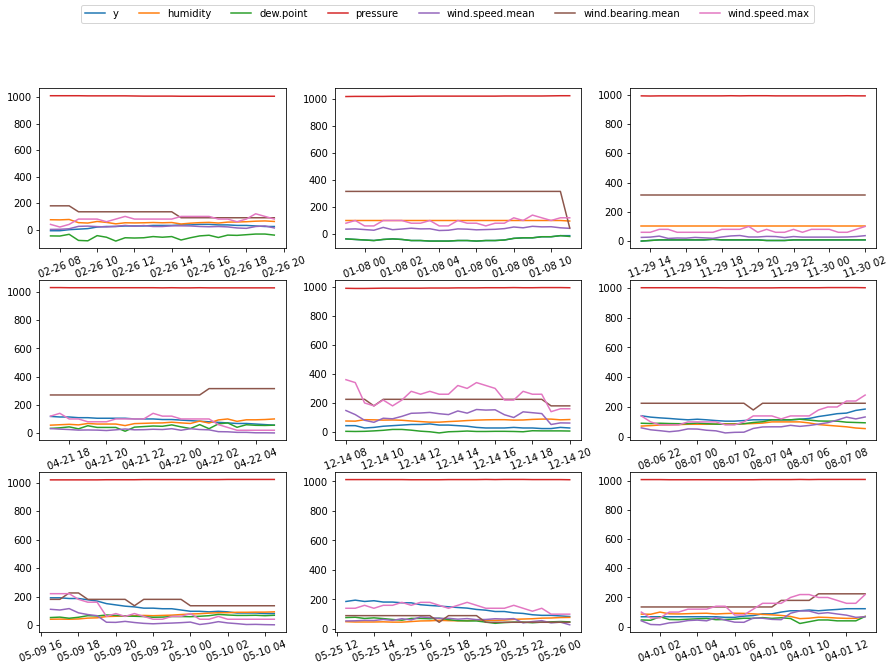

In [3]:
if 'google.colab' in str(get_ipython()):
    data_loc = "https://github.com/makeyourownmaker/CambridgeTemperatureModel/blob/master/data/CamUKWeather.csv?raw=true"
else:
    data_loc = "../data/CamUKWeather.csv"
df = pd.read_csv(data_loc, parse_dates = True)

df['ds'] = pd.to_datetime(df['ds'])

print("Shape:")
print(df.shape)
print("\nInfo:")
print(df.info())
print("\nSummary stats:")
display(df.describe())
print("\nRaw data:")
display(df)
print("\n")


def plot_examples(data, x_var):
    """Plot 9 sets of observations in 3 * 3 matrix ..."""

    assert len(data) == 9

    cols = [col for col in data[0].columns if col != x_var]

    fig, axs = plt.subplots(3, 3, figsize = (15, 10))
    axs = axs.ravel()  # apl for the win :-)

    for i in range(9):
      for col in cols:
        axs[i].plot(data[i][x_var], data[i][col])
        axs[i].xaxis.set_tick_params(rotation = 20, labelsize = 10)
    
    fig.legend(cols, loc = 'upper center',  ncol = len(cols))
    
    return None


cols = ['ds', 'y', 'humidity', 'dew.point', 'pressure', 
        'wind.speed.mean', 'wind.bearing.mean', 'wind.speed.max']
plots  = 9
window = 24
starts = [random.randint(0, np.floor(df.shape[0] / window)) for _ in range(plots)]
p_data = [df.loc[starts[i] * window:starts[i] * window + window, cols] 
          for i in range(plots)]
plot_examples(p_data, 'ds')



---

## Data Processing and Feature Engineering

The data must be reformatted before model building.

The following steps are necessary:
 * Wind direction and speed transformation
 * Impute missing data where possible
 * Time conversion
 * Split data
 * Normalise data
 * Window data


### Wind direction and speed transformation

The `wind.bearing.mean` column gives wind direction in degrees but is categorised at 45 degree increments, 
i.e. 0, 45, 90, 135, 180, 225, 270, 315.  Wind direction shouldn't matter if the wind is not blowing.

The distribution of wind direction and speed looks like this:

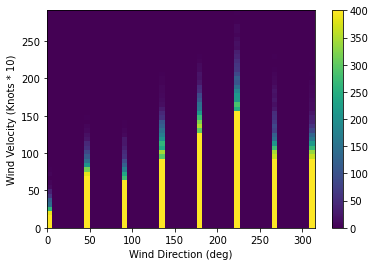

In [4]:
plt.hist2d(df['wind.bearing.mean'], df['wind.speed.mean'], bins = (50, 50), vmax = 400)
plt.colorbar()
plt.xlabel('Wind Direction (deg)')
plt.ylabel('Wind Velocity (Knots * 10)');

Convert wind direction and speed to _x_ and _y_ vectors, so the model can more easily interpret them.

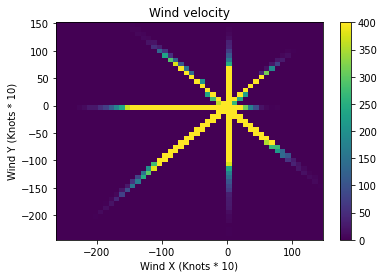

In [5]:
wv = df['wind.speed.mean']
max_wv = df['wind.speed.max']

# Convert to radians
wd_rad = df['wind.bearing.mean'] * np.pi / 180

# Calculate the wind x and y components
df['wind.x'] = wv * np.cos(wd_rad)
df['wind.y'] = wv * np.sin(wd_rad)

# Calculate the max wind x and y components
df['max.wind.x'] = max_wv * np.cos(wd_rad)
df['max.wind.y'] = max_wv * np.sin(wd_rad)

df_orig = df

plt.hist2d(df['wind.x'], df['wind.y'], bins = (50, 50), vmax = 400)
plt.colorbar()
plt.xlabel('Wind X (Knots * 10)')
plt.ylabel('Wind Y (Knots * 10)')
plt.title('Wind velocity');

Better, but not ideal.  Data augmentation with the 
[mixup](https://arxiv.org/abs/1710.09412) method is carried out at batch preparation time below.

From the paper:
"mixup trains a neural network on convex combinations of pairs of examples and their labels".

Further details on how I apply mixup to time series are included in the Window data section below.

Here is an illustration of the improvement in wind velocity with mixup augmentation.

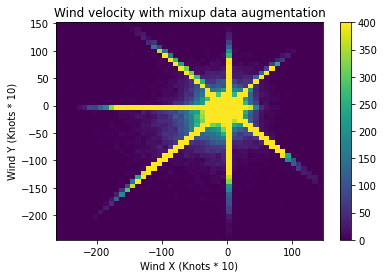

In [6]:
def mixup(data, alpha = 1.0, factor = 1):
    batch_size = len(data) - 1
    
    data['epoch'] = data.index.astype(np.int64) // 10**9
    
    # random sample lambda value from beta distribution
    l   = np.random.beta(alpha, alpha, batch_size * factor)
    X_l = l.reshape(batch_size * factor, 1)
    
    # Get a pair of inputs and outputs
    y1  = data['y'].shift(-1).dropna()
    y1_ = pd.concat([y1] * factor)
    
    y2  = data['y'][0:batch_size]
    y2_ = pd.concat([y2] * factor)

    X1  = data.drop('y', 1).shift(-1).dropna()
    X1_ = pd.concat([X1] * factor)
    
    X2  = data.drop('y', 1)
    X2  = X2[0:batch_size]
    X2_ = pd.concat([X2] * factor)

    # Perform mixup
    X = X1_ * X_l + X2_ * (1 - X_l)
    y = y1_ * l   + y2_ * (1 - l)    
    
    df = pd.DataFrame(y).join(X)    
    df = data.append(df).sort_values('epoch', ascending = True)
    df = df.drop('epoch', 1)
    
    df = df.drop_duplicates(keep = False)
    
    return df


df_mix = mixup(df.loc[:, ['y','wind.x','wind.y']], factor = 2)
plt.hist2d(df_mix['wind.x'], df_mix['wind.y'], bins = (50, 50), vmax = 400)
plt.colorbar()
plt.xlabel('Wind X (Knots * 10)')
plt.ylabel('Wind Y (Knots * 10)')
plt.title('Wind velocity with mixup data augmentation');

Mixup improves the categorical legacy of the wind velocity data.
Unfortunately, if outliers are present their influence will be reinforced.


### Missing value interpolation

Missing data is much less of a problem for [prophet models](https://github.com/makeyourownmaker/BayesianProphet)
which handle it seamlessly.

Currently there are around 8,000 missing observations in approximately 600 sections or "gaps".
The gaps range in length from 30 mins to 45 days.

Gaps have length across variables, i.e. if there is a gap of length 6 (3 hours) then all variables are missing for 6 consecutive observations.

Missing observations can be [imputed](https://en.wikipedia.org/wiki/Imputation_(statistics)).  
Here I use a variation on
[cubic interpolation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.PchipInterpolator.html).
Vanilla cubic interpolation overshoots the data which introduces outlier values.
I limit the gap length to 12 observations (6 hours).

Longer gaps will be accounted for at the train, test, validation split stage.

/usr/local/lib/python3.7/dist-packages/scipy/interpolate/_cubic.py:293: RuntimeWarning: invalid value encountered in add
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)


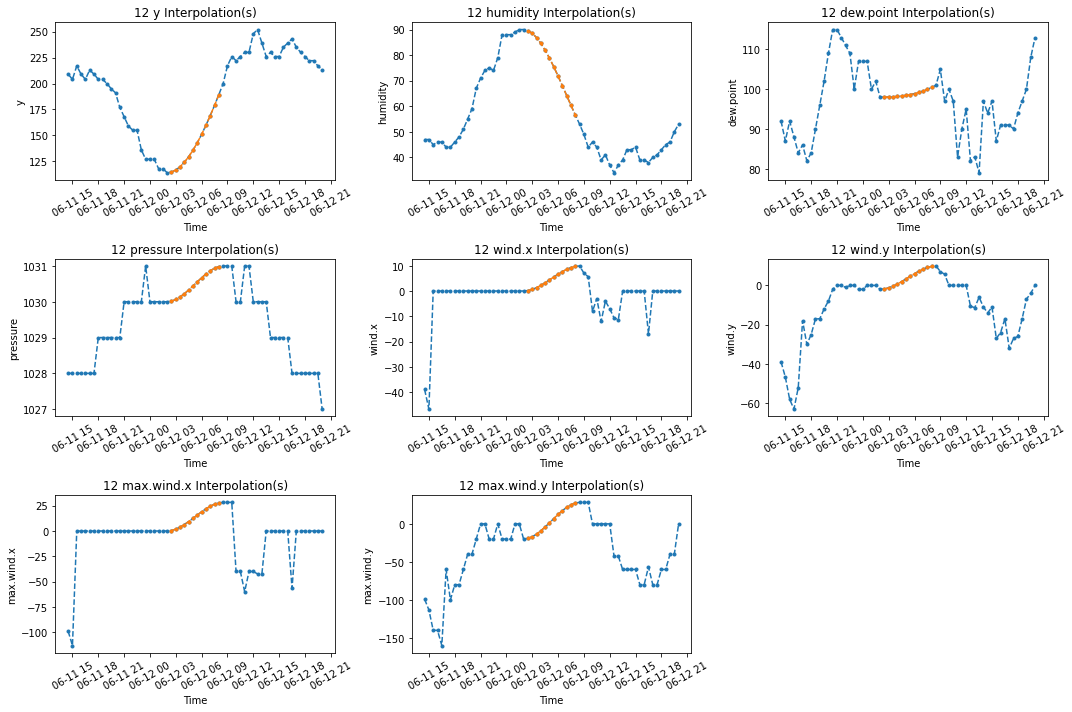

In [7]:
del_cols = ['doy', 'wind.bearing.mean', 'wind.speed.mean', 'wind.speed.max']
df_ts = df_orig.set_index('ds', drop = False)
df_ts.drop(del_cols, axis = 1, inplace = True)

# Add NaN values for missing observations
df_ts_na = df_ts.asfreq('30min')

# Set NaN year, time values using index
df_ts_na.ds   = df_ts_na.index
df_ts_na.year = df_ts_na.index.year
df_ts_na.time = df_ts_na.index.time

# Count number of consecutive missing values
#   There are more elegant ways to do this but they don't cope well with NaNs
#   As far as I can tell, neither numpy nor pandas have native run length encoding functions
len_holes = pd.Series([len(list(g)) for k, g in itertools.groupby(df_ts_na.y.isnull()) if k])
len_holes_long = pd.Series(list(itertools.repeat(l, l)) for l in len_holes)
len_holes_flat = pd.Series(list(itertools.chain(*len_holes_long)))

df_ts_na['missing_len'] = -100
df_ts_na['missing_len'] = df_ts_na['missing_len'].astype('Int64')
df_ts_na.loc[df_ts_na.y.isnull(), 'missing_len'] = len_holes_flat.to_numpy()

# Mark 24 observations before and after each group of NaNs - for plotting
df_ts_na['around_nan'] = -100
df_ts_na['around_nan'] = df_ts_na['around_nan'].astype('Int64')

for i in range(-24, 25):
    df_ts_na.loc[df_ts_na.y.isna().shift(i).fillna(False), 'around_nan'] = i
    
df_ts_na.loc[df_ts_na.y.isna(), 'around_nan'] = 0


# Interpolate - method = 'spline' very slow :-(
#               cubic and quadratic overshoot the data and introduce outliers
limit  = 12
method = 'pchip'
for v in ['y', 'humidity', 'dew.point', 'pressure', 'wind.x', 'wind.y', 'max.wind.x', 'max.wind.y']:
    df_ts_na[v] = df_ts_na[v].interpolate(method = method, limit = limit)


# Extract missing observations and surrounding values into dict of lists for checking & plotting
# slow :-(
j = miss_len = 0
inner_list = []
miss_plus  = {}
for index, row in df_ts_na.iterrows():
    if (row['around_nan'] > -25) | (row['missing_len'] > 0):
        inner_list.append(index)
        if row['missing_len'] > 0:
            miss_len = row['missing_len']
        j  = 1
    else:
        if j == 1:
            miss_plus.setdefault(miss_len, []).append(inner_list)
            inner_list = []
        j = miss_len = 0

# print("keys: ",  len(miss_plus.keys()))
# print("sum:  ",  sum(miss_plus.keys()))
# print("keys:  ", sorted(miss_plus.keys()))
# print(len(miss_plus[29]))
# print(len(miss_plus[29][0]))
# print(miss_plus[29][0])
# df_ts_na.loc[miss_plus[29][0]]        


def plot_interpolations(data):
    """Plot 8 labeled interpolation examples in 3 x 3 subplots"""

    fig, axs = plt.subplots(3, 3, figsize = (15, 10), tight_layout = True)
    axs = axs.ravel()
    i = 0

    for v in ['y', 'humidity', 'dew.point', 'pressure', 'wind.x', 'wind.y', 'max.wind.x', 'max.wind.y']:    
        marks = data.loc[data.missing_len > 0, v]
        title = str(len(marks)) + ' ' + v + ' Interpolation(s)'

        axs[i].plot(data[v], marker = '.', linestyle = '--')
        axs[i].plot(marks, marker = '.', linestyle = '--')
        axs[i].xaxis.set_tick_params(rotation = 30, labelsize = 10)
        axs[i].set_title(title)
        axs[i].set_ylabel(v)
        axs[i].set_xlabel('Time')
        i += 1

    axs[i].set_visible(False)
    
    return None


plot_interpolations(df_ts_na.loc[miss_plus[12][1]])


# Remove gaps longer than 12
df_ts_na = df_ts_na.dropna()
drop_cols = ['missing_len', 'around_nan']
df_ts_na.drop(drop_cols, axis = 1, inplace = True)
df = df_ts_na

There is a 23 % reduction in missing values.

Alternative interpolation methods (piecewise methods in particular) may give more natural results for the wind and pressure variables.


### Time conversion

Convert `ds` timestamps to "time of day" and "time of year" variables using `sin` and `cos`.

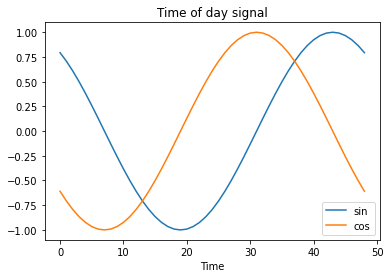

In [8]:
# Convert to secs
date_time   = pd.to_datetime(df['ds'], format = '%Y.%m.%d %H:%M:%S')
timestamp_s = date_time.map(datetime.datetime.timestamp)

day  = 24 * 60 * 60
year = (365.2425) * day

df['day.sin']  = np.sin(timestamp_s * (2 * np.pi / day))
df['day.cos']  = np.cos(timestamp_s * (2 * np.pi / day))
df['year.sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['year.cos'] = np.cos(timestamp_s * (2 * np.pi / year))

plt.plot(np.array(df['day.sin'])[:49])
plt.plot(np.array(df['day.cos'])[:49])
plt.xlabel('Time')
plt.legend(['sin', 'cos'], loc = 'lower right')
plt.title('Time of day signal');

### Split data

Use data from 2018 for validation and 2019 for testing.  These are entirely arbitrary choices.
This results in an approximate 82%, 9%, 9% split for the training, validation, and test sets.

In [9]:
keep_cols = ['y', 'humidity', 'dew.point', 'pressure', 'wind.x', 'wind.y',
             'day.sin', 'day.cos', 'year.sin', 'year.cos']
del_cols = ['ds', 'time', 'max.wind.x', 'max.wind.y']
df.drop(del_cols, axis = 1, inplace = True)

train_df = df.loc[(df['year'] != 2018) & (df['year'] != 2019)]
valid_df = df.loc[df['year'] == 2018]
test_df  = df.loc[df['year'] == 2019]

train_df = train_df.drop('year', axis = 1)  # inplace = True gives SettingWithCopyWarning
valid_df = valid_df.drop('year', axis = 1)  # ...
test_df  = test_df.drop('year',  axis = 1)
df       = df.drop('year',       axis = 1)

print("df.drop shape: ", df.shape)
print("train shape:   ", train_df.shape)
print("valid shape:   ", valid_df.shape)
print("test shape:    ", test_df.shape)

df.drop shape:  (194736, 10)
train shape:    (160059, 10)
valid shape:    (17236, 10)
test shape:     (17441, 10)


### Normalise data

Features should be scaled before neural network training.  Arguably, scaling should be done using moving averages to avoid accessing future values.  
Instead, simple [standard score](https://en.wikipedia.org/wiki/Standard_score) 
normalisation will be used.

Plot [violin plot](https://en.wikipedia.org/wiki/Violin_plot) 
to see distribution of features.

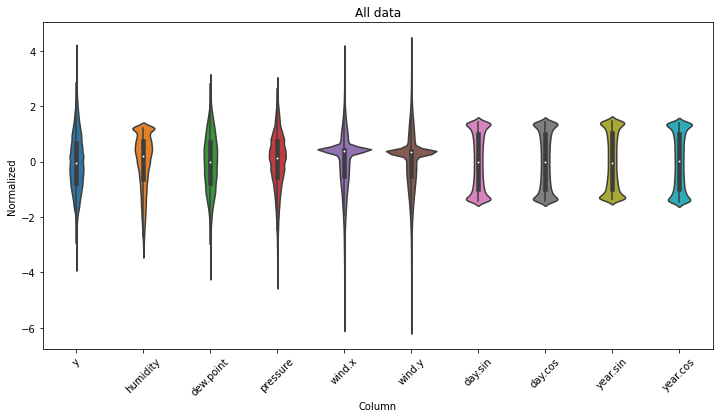

In [10]:
train_mean = train_df.mean()
train_std  = train_df.std()

train_df = (train_df - train_mean) / train_std
valid_df = (valid_df - train_mean) / train_std
test_df  = (test_df  - train_mean) / train_std

df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name = 'Column', value_name = 'Normalized')

plt.figure(figsize=(12, 6))
ax = sns.violinplot(x = 'Column', y = 'Normalized', data = df_std)
ax.set_xticklabels(df.keys(), rotation = 45)
ax.set_title('All data');

There may still be some outliers present but there are no glaring problems.


### Window data

Models are trained using sliding windows of samples from the data.

Window parameters to consider for the 
[tf.keras.preprocessing.timeseries_dataset_from_array](https://keras.io/api/preprocessing/timeseries/#timeseries-data-preprocessing)
function:
 * sequence_length: 
   * Length of the output sequences (in number of timesteps), or number of **lag** observations to use
 * sequence_stride: 
   * Period between successive output sequences.  For stride s, output samples start at index data[i], data[i + s], data[i + 2 * s] etc
   * s can include an **offset** and/or 1 or more **steps ahead** to forecast
 * batch_size: 
   * Number of samples in each batch
 * shuffle: 
   * Shuffle output samples, or use chronological order
 
Initial values used:
 * sequence_length (aka lags): 24 (corresponds to 12 hours)
 * steps ahead (what to forecast): 1 and separately 4 (corresponds to 30 mins and separately 30 mins, 60 mins, 90 mins, 120 mins)
 * offset (space between lags and steps ahead): 0
 * batch_size: 32
 * shuffle: True for training data
 
The `make_dataset` function below generates [tensorflow datasets](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) for:
 * Lags, steps-ahead, offset, batch size and shuffle
 * Optionally multiple y columns (Not extensively tested)
 
Stride is used to specify offset + steps-ahead.  Offset will be 0 throughout this notebook.

**TODO** Insert figure illustrating lags, offsets and steps-ahead.

`shuffle = True` is used with train data.
`shuffle = False` is used with validation and test data so the residuals can be checked for heteroscadicity.

Throughout this notebook I use a shorthand notation to describe lags and strides.  For example:
 * 24l_1s is 24 lags 1 step ahead
 * 24l_4s is 24 lags 4 steps ahead

#### Mixup data augmentation

Data augmentation with [mixup: Beyond Empirical Risk Minimization](https://arxiv.org/abs/1710.09412) by Zhang *et al* is used to help counter the categorical legacy from the wind bearing variable.  Simple 'input mixup' is used as opposed to the batch-based mixup Zhang *et al* focus on.  Input mixup has the advantage that it can be used with non-neural network methods.  Mixup is performed for train and validation data separately.  With current settings these datasets are approximately 3 times larger but this can be varied.  Three times more training data is manageable on Colab.  Test and validation data is left unmodified.

I apply mixup between consecutive observations in the time series instead of the usual random observations.  This is a fairly conservative starting point.  I'd be surprised if applying mixup between consecutive days of measurements didn't give better results.  Applying mixup between inputs with equal temperature values will not improve performance and will increase run time.

**TODO** Insert couple of examples of mixup - use `plot_examples()`

I don't show it in this notebook, but adding this data augmentation makes a big difference to loss values for all three model architectures.  For example, here are comparable results for MLP, 24 largs, 1 step ahead, 20 epochs.

| Augmentation    | Train rmse | Train mae | Valid rmse | Valid mae |
|-----------------|------------|-----------|------------|-----------|
| No augmentation | 0.0058     | 0.053     | 0.0054     | 0.052     |
| Input mixup     | 0.0016     | 0.025     | 0.0015     | 0.025     |

See this [commit](https://github.com/makeyourownmaker/CambridgeTemperatureModel/blob/93c754d4b1b02e1bd8f827a6f6edc145824f6d23/notebooks/keras_mlp_fcn_resnet_time_series.ipynb) for results from other architectures without input mixup.

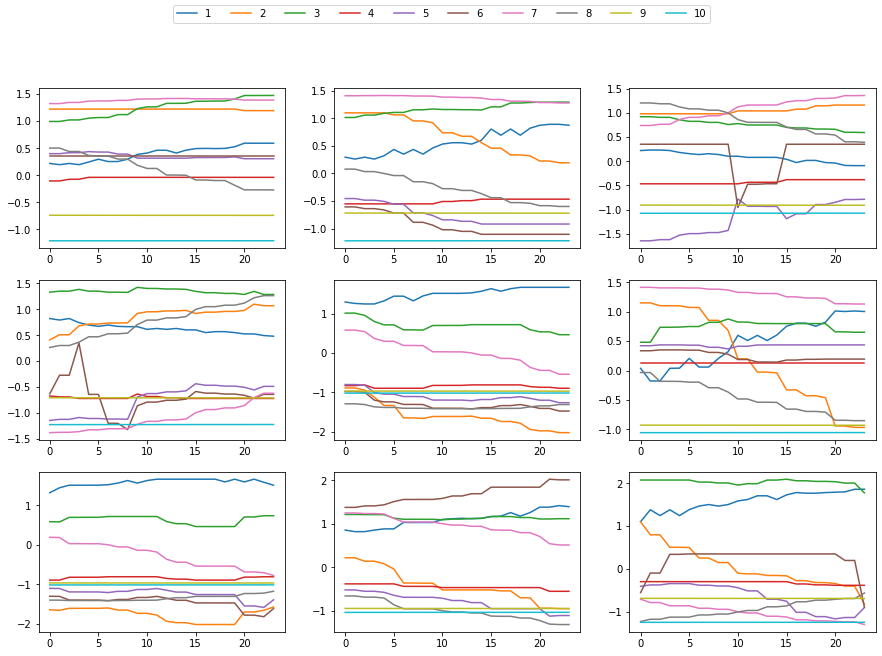

In [11]:
def make_dataset(data, y_cols, lags = 1, steps_ahead = 1, stride = 1, bs = 32, shuffle = False, mix = 2):    
    assert stride >= steps_ahead

    total_window_size = lags + stride
    
    # Add NaN values for missing observations
    data = data.asfreq('30min')
    
    # Split data into subsets (blocks) on NaNs - SLOW - https://stackoverflow.com/a/21404655/100129
    blocks = np.split(data, np.where(np.isnan(data.y))[0])
    # Removing NaN entries
    blocks = [bl[~np.isnan(bl.y)] for bl in blocks if not isinstance(bl, np.ndarray)]
    # Removing empty DataFrames
    blocks = [bl for bl in blocks if not bl.empty]
    
    i = 0    
    for block in blocks:
        i += 1
        if mix != 0:
            block_mix = mixup(block, factor = mix)
        else:
            block_mix = block
        block_np  = np.array(block_mix, dtype = np.float32)
        
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
               data    = block_np,
               targets = None,
               sequence_length = total_window_size,
               sequence_stride = 1,
               shuffle    = shuffle,
               batch_size = bs)
            
        col_indices = {name: i for i, name in enumerate(data.columns)}    
        X_slice = slice(0, lags)
        y_start = total_window_size - steps_ahead
        y_slice = slice(y_start, None)

    
        def split_window(features):   
            X = features[:, X_slice, :]
            y = features[:, y_slice, :]

            X = tf.stack(
                [X[:, :, col_indices[name]] for name in data.columns],
                axis = -1)    
            y = tf.stack(
                [y[:, :, col_indices[name]] for name in y_cols],
                axis = -1)

            # Slicing doesn't preserve static shape information, so set the shapes manually.
            # This way the `tf.data.Datasets` are easier to inspect.
            X.set_shape([None, lags,        None])
            y.set_shape([None, steps_ahead, None])

            return X, y

    
        ds = ds.map(split_window)
        
        if i == 1:
            combined_dataset = ds
        else:
            combined_dataset = combined_dataset.concatenate(ds)
        
    return combined_dataset


def make_datasets(train, valid, test, 
                  y_cols = 'y', lags = 1, steps_ahead = 1, 
                  stride = 1, bs = 32, shuffle = False):
    ds_train = make_dataset(train, y_cols, 
                            lags = lags, steps_ahead = steps_ahead, 
                            stride = stride, shuffle = shuffle)
    ds_valid = make_dataset(valid, y_cols, 
                            lags = lags, steps_ahead = steps_ahead, 
                            stride = stride, shuffle = False)
    ds_test  = make_dataset(test,  y_cols, 
                            lags = lags, steps_ahead = steps_ahead, 
                            stride = stride, shuffle = False, mix = 0)
    
    return ds_train, ds_valid, ds_test


def dataset_sanity_checks(data, name):    
    print(name, "batches: ", data.cardinality().numpy())
    for batch in data.take(1):
        print("\tX (batch_size, time, features): ", batch[0].shape)
        print("\ty (batch_size, time, features): ", batch[1].shape)
        print("\tX[0][0]: ", batch[0][0])
        print("\ty[0][0]: ", batch[1][0])
    

# Single step-ahead
ds = {}
bs = 32
shuffle = True
ds['train_24l_1s'], ds['valid_24l_1s'], ds['test_24l_1s'] = make_datasets(train_df, 
                                                                          valid_df, 
                                                                          test_df, 
                                                                          lags = 24, 
                                                                          shuffle = shuffle, 
                                                                          bs = bs)
# dataset_sanity_checks(ds_train_4l_1s, '4l 1s train');


# 4 steps-ahead
steps = stride = 4
ds['train_24l_4s'], ds['valid_24l_4s'], ds['test_24l_4s'] = make_datasets(train_df, 
                                                                          valid_df, 
                                                                          test_df, 
                                                                          lags = 24, 
                                                                          steps_ahead = steps, 
                                                                          stride = stride, 
                                                                          shuffle = shuffle, 
                                                                          bs = bs)

# lags = 4
# display(train_df.head(lags + steps))
# dataset_sanity_checks(ds_train_4l_4s, '4l 4s train');


# Plot 9 examples from ds['train_24l_1s']
def plot_dataset_examples(dataset):
    fig, axs = plt.subplots(3, 3, figsize = (15, 10))
    axs = axs.ravel() 

    for batch in dataset.take(1):
        for i in range(9):
          x = batch[0][i].numpy()
          axs[i].plot(x)

    fig.legend(range(1, 11), loc = 'upper center',  ncol = 10);


plot_dataset_examples(ds['train_24l_1s'])


---


## Model Building

Model architectures considered:
 * MLP
 * [FCN](https://arxiv.org/abs/1611.06455)
 * ResNet
 * LSTM
 
The architectures considered were inspired by those used by Wang *et al* in 
[Time Series Classification from Scratch with Deep
Neural Networks: A Strong Baseline](https://arxiv.org/abs/1611.06455).
Initial hyperparameter settings came from 
[Deep learning for time series classification: a review](https://link.springer.com/article/10.1007%2Fs10618-019-00619-1).

I'm primarily interested in "now-casting" or forecasting in the next 1 or 2 hours.
The following model outputs are investigated:
 * Single step ahead - 30 mins
 * Multi-step ahead - 30, 60, 90 and 120 mins

The training and validation code are stored in the `compile_fit_validate` function below.


### Multi-layer perceptron

It is useful to check the performance of the multi-layer perceptron (MLP) before using more sophisticated models.
The MLP is described in the `build_mlp_model` function below.  It deviates from the Wang *et al*/Fawaz *et al* model.
Specifically, I use a `Flatten` layer for the first layer to train on multiple input lags, reduce the number of layers from 3 to 2 and reduce the number of neurons in each layer from 500 to 64.

First, check single step-ahead predictions.

In [12]:
def compile_fit_validate(model, train, valid, optimizer, epochs = 5, verbose = 2):
    # Reduces variance in results but won't eliminate it :-(
    random.seed(42)
    np.random.seed(42)
    tf.random.set_seed(42)
    
    if optimizer.lower() == 'adadelta':
        opt = Adadelta(lr = 1.0)
    else:
        opt = Adam(lr = 0.001)
        
    es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 10)
    lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 5, min_lr = 0.0001)

    model.compile(optimizer = opt, loss = 'mse', metrics = ['mae', 'mape'])    
    h = model.fit(train, validation_data = valid,
                  epochs = epochs, verbose = verbose, callbacks = [es, lr])
    
    return h

    
def plot_history(h, name, epochs = 10):
    fig, axs = plt.subplots(1, 2, figsize = (9, 6), tight_layout = True)
    axs = axs.ravel()

    axs[0].plot(h.history['loss'])
    axs[0].plot(h.history['val_loss'])
    axs[0].set_title(name + ' loss')
    axs[0].set_xticklabels(range(1, epochs + 1))
    axs[0].set_xticks(range(0, epochs))
    axs[0].set_ylabel('loss')
    axs[0].set_xlabel('epoch')
    axs[0].legend(['train', 'valid'], loc = 'upper right')

    axs[1].plot(h.history['mape'])
    axs[1].plot(h.history['val_mape'])
    axs[1].set_title(name + ' mape')
    axs[1].set_xticks(range(0, epochs))
    axs[1].set_xticklabels(range(1, epochs + 1))
    axs[1].set_title(name + ' mape')
    axs[1].set_ylabel('mape')
    axs[1].set_xlabel('epoch')
    axs[1].legend(['train', 'valid'], loc = 'upper right')
    plt.show()

    return None

    
def print_min_loss(h, name):
    argmin_loss     = np.argmin(np.array(h.history['loss']))
    argmin_val_loss = np.argmin(np.array(h.history['val_loss']))
    min_loss        = h.history['loss'][argmin_loss]
    min_val_loss    = h.history['val_loss'][argmin_val_loss]
    mape            = h.history['mape'][argmin_loss]
    val_mape        = h.history['val_mape'][argmin_val_loss]
    mae             = h.history['mae'][argmin_loss]
    val_mae         = h.history['val_mae'][argmin_val_loss]
    
    txt = "{0:s} {1:s} min loss: {2:f}\tmae: {3:f}\tmape: {4:f}\tepoch: {5:d}"
    print(txt.format(name, "train", min_loss,     mae,     mape,     argmin_loss + 1))
    print(txt.format(name, "valid", min_val_loss, val_mae, val_mape, argmin_val_loss + 1))
    print()

    return None


def get_io_shapes(data):
    for batch in data.take(1):
        in_shape  = batch[0][0].shape
        out_shape = batch[1][0].shape
        
    return in_shape, out_shape


def build_mlp_model(name, data, neurons = 64):
    in_shape, out_shape = get_io_shapes(data)
    out_steps = out_shape[0]
    
    mlp = Sequential(name = name)
    
    mlp.add(Input(shape = in_shape))
    mlp.add(Flatten())  # Shape: (time, features) => (time*features)
    # mlp.add(Dropout(0.1))
    
    mlp.add(Dense(neurons, activation = 'relu'))
    # mlp.add(Dropout(0.1))
    
    mlp.add(Dense(neurons, activation = 'relu'))
    # mlp.add(Dropout(0.1))
    
    mlp.add(Dense(out_steps))   
    mlp.add(Reshape([1, -1]))
    
    return mlp


def run_model(model, train, valid, optimizer = 'adam', epochs = 5):
    in_shape, out_shape = get_io_shapes(train)
    model_id = model.name + ' model - ' + str(in_shape[0]) + \
               ' lags ' + str(out_shape[0]) + ' steps-ahead -'
    
    model.summary()
    h = compile_fit_validate(model, train, valid, optimizer, epochs)
    plot_history(h, model_id, epochs)
    print_min_loss(h, model_id)
    
    return h

 
h = {}  # history
name = 'MLP'
models = {}
models['mlp_24l_1s'] = build_mlp_model(name, ds['train_24l_1s'])
models['mlp_24l_4s'] = build_mlp_model(name, ds['train_24l_4s'])

### Learning rate finder

Leslie Smith was one of the first people to work on finding optimal learning rates for deep learning networks in [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/abs/1506.01186).  Jeremy Howard from [fast.ai](https://www.fast.ai/) popularised the learning rate finder used here.

Before building any models, I use a modified version of [Pavel Surmenok's Keras learning rate finder](https://github.com/surmenok/keras_lr_finder) to get reasonably close to the optimal learning rate.  It's a single small class which I add support for tensorflow datasets to, customise the graphics and add a simple summary function to. 

Epoch 1/5
18904/18904 [==============================] - 32s 2ms/step - loss: 13.8065 - mae: 0.2728 - mape: 118.5735


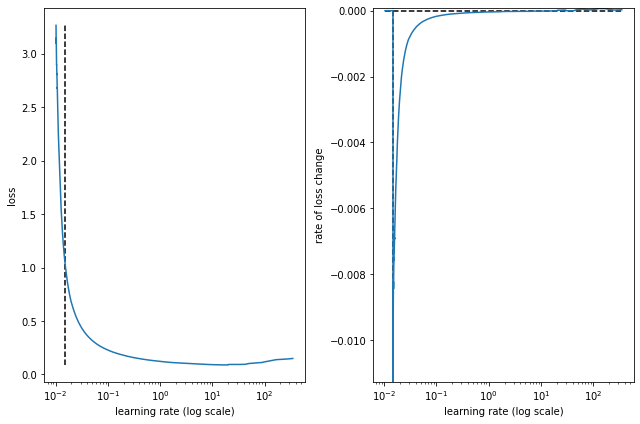

best lr: 0.014789497 

Epoch 1/5
18869/18869 [==============================] - 33s 2ms/step - loss: 21.2164 - mae: 0.3185 - mape: 152.5291


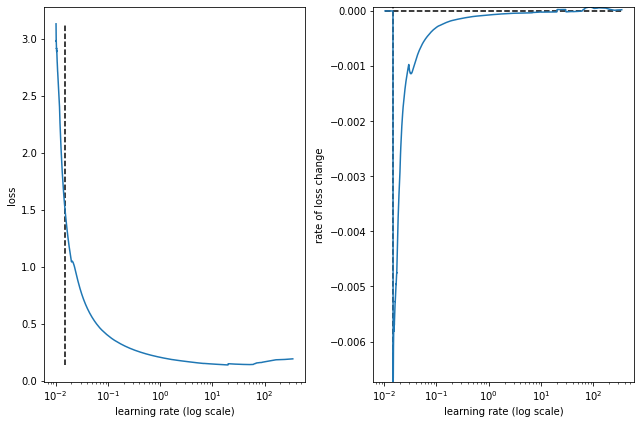

best lr: 0.014892996 



In [20]:
from keras.callbacks import LambdaCallback
import keras.backend as K
import math


class LRFinder:
    """
    Plots the change of the loss function of a Keras model when the learning rate is exponentially increasing.
    See for details:
    https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0
    """

    def __init__(self, model):
        self.model = model
        self.losses = []
        self.lrs = []
        self.best_loss = 1e9

    def on_batch_end(self, batch, logs):
        # Log the learning rate
        lr = K.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)

        # Log the loss
        loss = logs['loss']
        self.losses.append(loss)

        # Check whether the loss got too large or NaN
        if batch > 5 and (math.isnan(loss) or loss > self.best_loss * 4):
            self.model.stop_training = True
            return

        if loss < self.best_loss:
            self.best_loss = loss

        # Increase the learning rate for the next batch
        lr *= self.lr_mult
        K.set_value(self.model.optimizer.lr, lr)

    def find_ds(self, train_ds, start_lr, end_lr, batch_size=64, epochs=1, **kw_fit):
        # If x_train contains data for multiple inputs, use length of the first input.
        # Assumption: the first element in the list is single input; NOT a list of inputs.
        # N = x_train[0].shape[0] if isinstance(x_train, list) else x_train.shape[0]
        N = train_ds.cardinality().numpy()

        # Compute number of batches and LR multiplier
        num_batches = epochs * N / batch_size
        self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(num_batches))
        #print(self.lr_mult)
        # Save weights into a file
        initial_weights = self.model.get_weights()

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.lr)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch, logs: self.on_batch_end(batch, logs))

        self.model.fit(train_ds,
                       batch_size=batch_size, epochs=epochs,
                       callbacks=[callback],
                       **kw_fit)

        # Restore the weights to the state before model fitting
        self.model.set_weights(initial_weights)

        # Restore the original learning rate
        K.set_value(self.model.optimizer.lr, original_lr)

    def plot_loss(self, axs, sma, n_skip_beginning=10, n_skip_end=5, x_scale='log'):
        """
        Plots the loss.
        Parameters:
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
        """
        lrs = self.lrs[n_skip_beginning:-n_skip_end]
        losses = self.losses[n_skip_beginning:-n_skip_end]
        best_lr = self.get_best_lr(sma=sma, n_skip_beginning=10, n_skip_end=5)

        axs[0].set_ylabel("loss")
        axs[0].set_xlabel("learning rate (log scale)")
        axs[0].plot(lrs, losses)
        axs[0].vlines(best_lr, np.min(losses), np.max(losses), linestyles='dashed')
        axs[0].set_xscale(x_scale)

    def plot_loss_change(self, axs, sma=1, n_skip_beginning=10, n_skip_end=5, y_lim=None):
        """
        Plots rate of change of the loss function.
        Parameters:
            axs - subplot axes
            sma - number of batches for simple moving average to smooth out the curve.
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
            y_lim - limits for the y axis.
        """
        derivatives = self.get_derivatives(sma)[n_skip_beginning:-n_skip_end]
        lrs = self.lrs[n_skip_beginning:-n_skip_end]
        best_lr = self.get_best_lr(sma=sma, n_skip_beginning=n_skip_beginning, n_skip_end=n_skip_end)
        y_min, y_max = np.min(derivatives), np.max(derivatives)
        x_min, x_max = np.min(lrs), np.max(lrs)

        axs[1].set_ylabel("rate of loss change")
        axs[1].set_xlabel("learning rate (log scale)")
        axs[1].plot(lrs, derivatives)
        axs[1].vlines(best_lr, y_min, y_max, linestyles='dashed')
        axs[1].hlines(0, x_min, x_max, linestyles='dashed')
        axs[1].set_xscale('log')
        if y_lim == None:
            axs[1].set_ylim([y_min, y_max])
        else:
            axs[1].set_ylim(y_lim)

    def get_derivatives(self, sma):
        assert sma >= 1
        derivatives = [0] * sma
        for i in range(sma, len(self.lrs)):
            derivatives.append((self.losses[i] - self.losses[i - sma]) / sma)
        return derivatives

    def get_best_lr(self, sma, n_skip_beginning=10, n_skip_end=5):
        derivatives = self.get_derivatives(sma)
        best_der_idx = np.argmin(derivatives[n_skip_beginning:-n_skip_end])
        return self.lrs[n_skip_beginning:-n_skip_end][best_der_idx]

    def summarise_lr(self, train_ds, start_lr, end_lr, batch_size=64, epochs=1, sma=1, n_skip_beginning=200, **kw_fit):
        self.find_ds(train_ds, start_lr, end_lr, batch_size, epochs)

        fig, axs = plt.subplots(1, 2, figsize = (9, 6), tight_layout = True)
        axs = axs.ravel()
        self.plot_loss(axs, sma)
        self.plot_loss_change(axs, sma=sma, n_skip_beginning=n_skip_beginning, n_skip_end=5)
        plt.show()

        best_lr = self.get_best_lr(sma=sma, n_skip_beginning=n_skip_beginning, n_skip_end=5)
        print("best lr:", best_lr, "\n")


lrf = {}
model = models['mlp_24l_1s']
model.compile(optimizer = 'adadelta', loss = 'mse', metrics = ['mae', 'mape'])
lrf_mlp_24l_1s = LRFinder(model)
lrf_mlp_24l_1s.summarise_lr(ds['train_24l_1s'], 0.01, 1, 32, 5, 250, 25)
lrf['mlp_24l_1s'] = lrf_mlp_24l_1s

model = models['mlp_24l_4s']
model.compile(optimizer = 'adadelta', loss = 'mse', metrics = ['mae', 'mape'])
lrf_mlp_24l_4s = LRFinder(model)
lrf_mlp_24l_4s.summarise_lr(ds['train_24l_4s'], 0.01, 1, 32, 5, 250, 25)
lrf['mlp_24l_4s'] = lrf_mlp_24l_4s

The learning rate finder has a surprisingly low run time; possibly because the loss quickly becomes infinite at high learning rates.

The learning rate finder has not been very useful with any of these architectures and this data (see below for results from the other architectures).  The models currently converge to the minimum loss value within 20 epochs with default learning rates.  So, I default back to the accepted learning rate of 1.0 for adadelta and 0.001 for adam.

The smoothing value `sma`, is relatively high for the MLPs.  It's possible to get lower rate of loss change values by using a lower `start_lr` but the rate of loss change has high variance in these regions.  For MLPs learning rates in the region 0.01 to 1.0 give acceptible rates of loss change.

I leave the learning rate finder code in this notebook for possible future personal reference.  It may also prove useful with other architectures and/or addition of exogenous regressors from for example the [Global Forecast System](https://www.ncdc.noaa.gov/data-access/model-data/model-datasets/global-forcast-system-gfs) model.

---


First, check single step-ahead model.

Model: "MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 240)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                15424     
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
_________________________________________________________________
reshape_2 (Reshape)          (None, 1, 1)              0         
Total params: 19,649
Trainable params: 19,649
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
18904/18904 - 70s - loss: 0.0060 - mae: 0.0527 - mape: 26.4303 - val_loss: 0.0044 - val_mae: 0.0504 - val_mape: 21

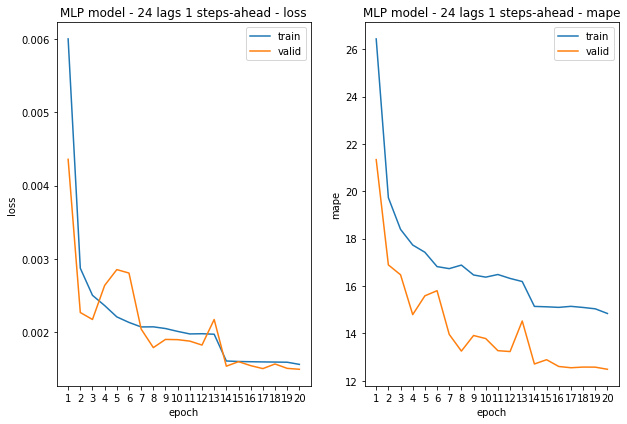

MLP model - 24 lags 1 steps-ahead - train min loss: 0.001565	mae: 0.025212	mape: 14.843611	epoch: 20
MLP model - 24 lags 1 steps-ahead - valid min loss: 0.001498	mae: 0.025037	mape: 12.488748	epoch: 20



In [22]:
h['mlp_24l_1s'] = run_model(models['mlp_24l_1s'], ds['train_24l_1s'], ds['valid_24l_1s'], optimizer = 'adadelta', epochs = 20)

Second, check multiple time-steps.

Model: "MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 240)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                15424     
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 260       
_________________________________________________________________
reshape_3 (Reshape)          (None, 1, 4)              0         
Total params: 19,844
Trainable params: 19,844
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
18869/18869 - 70s - loss: 0.0079 - mae: 0.0616 - mape: 48.5360 - val_loss: 0.0047 - val_mae: 0.0513 - val_mape: 26

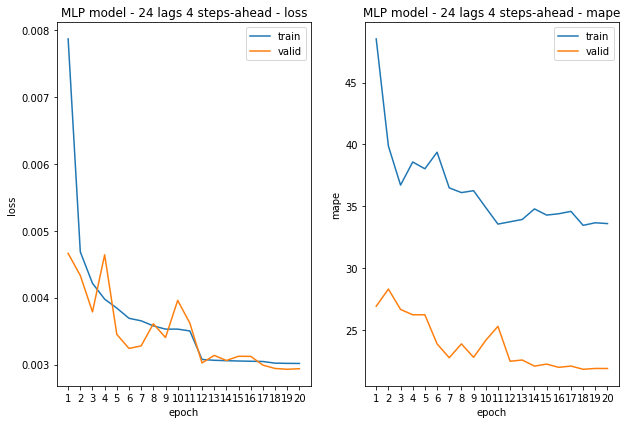

MLP model - 24 lags 4 steps-ahead - train min loss: 0.003016	mae: 0.037303	mape: 33.592682	epoch: 20
MLP model - 24 lags 4 steps-ahead - valid min loss: 0.002929	mae: 0.036922	mape: 21.871420	epoch: 19



In [23]:
h['mlp_24l_4s'] = run_model(models['mlp_24l_4s'], ds['train_24l_4s'], ds['valid_24l_4s'], optimizer = 'adadelta', epochs = 20)

### Fully convolutional network

See [Time Series Classification from Scratch with Deep Neural Networks: A Strong Baseline](https://arxiv.org/abs/1611.06455)
for a detailed description of the Fully Convolutional Network (FCN) architecture.  The FCN
was first described in
[Time-series modeling with undecimated fully convolutional neural networks](https://arxiv.org/abs/1508.00317).

The FCN architecture is a variant of the Convolutional Neural Network (CNN).  A Convolutional 
Neural Network (CNN) usually contains fully-connected layers or a MLP at the 
end of the network.  The FCN does not include these final layers, so it is learning 
convolutional filters everywhere.

**TODO** Include figure comparing FCNs and CNNs

The Keras [Conv1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D)
layer is used for temporal convolution.

Next, run the learning rate finder for FCNs.

Epoch 1/5
18904/18904 [==============================] - 25s 1ms/step - loss: 0.1970 - mae: 0.2458 - mape: 114.9170


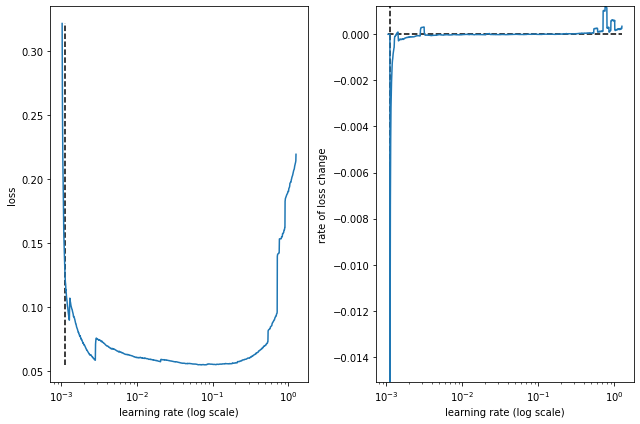

best lr: 0.0011266746 

Epoch 1/5
18869/18869 [==============================] - 25s 1ms/step - loss: 0.2256 - mae: 0.2510 - mape: 124.7014


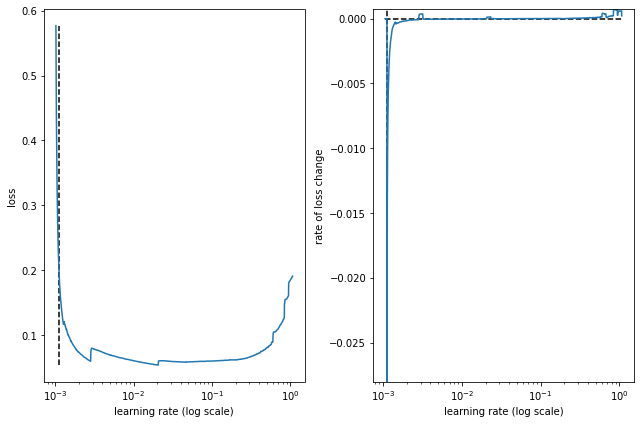

best lr: 0.0011242866 



In [25]:
def build_fcn_model(name, data, n_feature_maps = 64):
    in_shape, out_shape = get_io_shapes(data)
    out_steps = out_shape[0]
    
    fcn = Sequential(name = name)
    fcn.add(Input(shape = in_shape))
    
    fcn.add(Conv1D(filters = n_feature_maps, kernel_size = 8, padding = 'same'))
    fcn.add(BatchNormalization())
    fcn.add(Activation(activation = 'relu'))

    fcn.add(Conv1D(filters = n_feature_maps, kernel_size = 5, padding = 'same'))
    fcn.add(BatchNormalization())
    fcn.add(Activation(activation = 'relu'))

    fcn.add(Conv1D(filters = n_feature_maps, kernel_size = 3, padding = 'same'))
    fcn.add(BatchNormalization())
    fcn.add(Activation(activation = 'relu'))

    fcn.add(GlobalAveragePooling1D())
    fcn.add(Dense(out_steps))

    return fcn


name = 'FCN'
models['fcn_24l_1s'] = build_fcn_model(name, ds['train_24l_1s'])
models['fcn_24l_4s'] = build_fcn_model(name, ds['train_24l_4s'])


model = models['fcn_24l_1s']
model.compile(loss = 'mse', metrics = ['mae', 'mape'])
lrf_fcn_24l_1s = LRFinder(model)
lrf_fcn_24l_1s.summarise_lr(ds['train_24l_1s'], 0.001, 1, 32, 5, 50, 25)
lrf['fcn_24l_1s'] = lrf_fcn_24l_1s

model = models['fcn_24l_4s']
model.compile(loss = 'mse', metrics = ['mae', 'mape'])
lrf_fcn_24l_4s = LRFinder(model)
lrf_fcn_24l_4s.summarise_lr(ds['train_24l_4s'], 0.001, 1, 32, 5, 50, 25)
lrf['fcn_24l_4s'] = lrf_fcn_24l_4s

Best learning rates from the learning rate finder are close to the accepted adam learning rate of 0.001.  So, I default back to that value for FCNs.

---

First, check single step-ahead predictions.

Model: "FCN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_34 (Conv1D)           (None, 24, 64)            5184      
_________________________________________________________________
batch_normalization_36 (Batc (None, 24, 64)            256       
_________________________________________________________________
activation_30 (Activation)   (None, 24, 64)            0         
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 24, 64)            20544     
_________________________________________________________________
batch_normalization_37 (Batc (None, 24, 64)            256       
_________________________________________________________________
activation_31 (Activation)   (None, 24, 64)            0         
_________________________________________________________________
conv1d_36 (Conv1D)           (None, 24, 64)            12352   

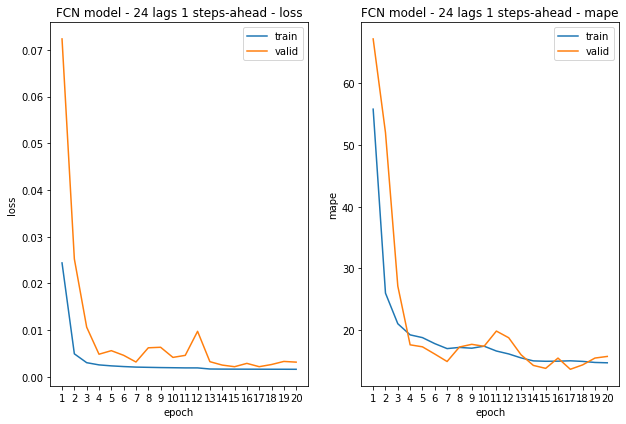

FCN model - 24 lags 1 steps-ahead - train min loss: 0.001631	mae: 0.026096	mape: 14.682421	epoch: 20
FCN model - 24 lags 1 steps-ahead - valid min loss: 0.002183	mae: 0.033800	mape: 13.779160	epoch: 15



In [26]:
h['fcn_24l_1s'] = run_model(models['fcn_24l_1s'], ds['train_24l_1s'], ds['valid_24l_1s'], epochs = 20)

Second, check multiple step-ahead predictions.

Model: "FCN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_37 (Conv1D)           (None, 24, 64)            5184      
_________________________________________________________________
batch_normalization_39 (Batc (None, 24, 64)            256       
_________________________________________________________________
activation_33 (Activation)   (None, 24, 64)            0         
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 24, 64)            20544     
_________________________________________________________________
batch_normalization_40 (Batc (None, 24, 64)            256       
_________________________________________________________________
activation_34 (Activation)   (None, 24, 64)            0         
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 24, 64)            12352   

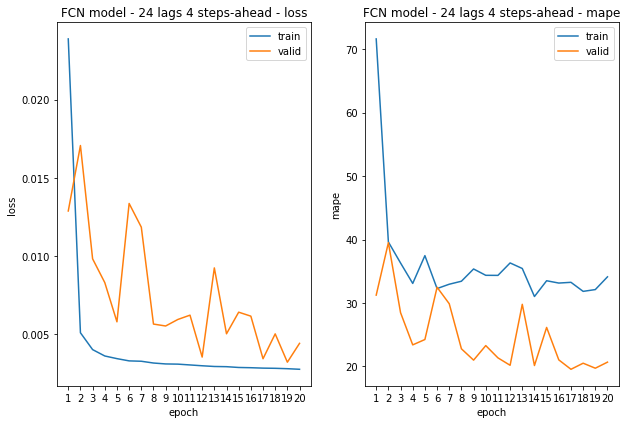

FCN model - 24 lags 4 steps-ahead - train min loss: 0.002759	mae: 0.036098	mape: 34.131786	epoch: 20
FCN model - 24 lags 4 steps-ahead - valid min loss: 0.003212	mae: 0.040593	mape: 19.731224	epoch: 19



In [27]:
h['fcn_24l_4s'] = run_model(models['fcn_24l_4s'], ds['train_24l_4s'], ds['valid_24l_4s'], epochs = 20)

### Residual network

Residual networks, or ResNets, were originally proposed in
[Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385).

Residual neural networks use "identity shortcut connections" to skip over some layers.  Typical ResNet models are implemented with blocks of layers that contain nonlinearities (ReLU) and batch normalization.
Skipping over layers may avoid the problem of vanishing gradients, by reusing activations from a previous layer until the adjacent layer learns its weights.  This should allow training networks with more layers.

**TODO** Include basic ResNet diagram

Again, the Keras [Conv1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D)
layer is used for temporal convolution.

Next, run the learning rate finder.

Epoch 1/5
18904/18904 [==============================] - 75s 2ms/step - loss: 0.5768 - mae: 0.3080 - mape: 143.1178


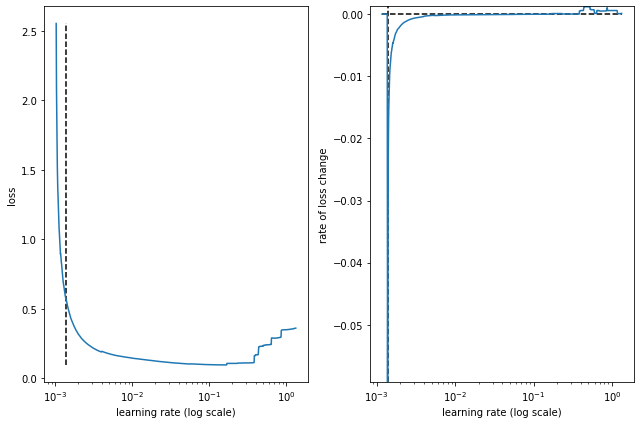

best lr: 0.0013744514 

Epoch 1/5
18869/18869 [==============================] - 40s 2ms/step - loss: 0.3239 - mae: 0.2483 - mape: 124.0002


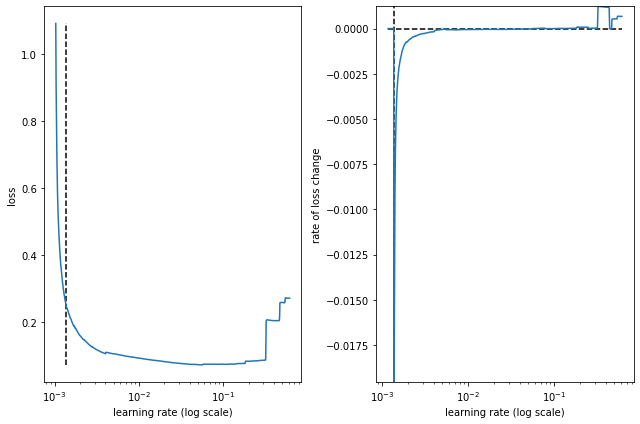

best lr: 0.0013752629 



In [25]:
 def build_resnet_model(name, data, n_feature_maps = 64):
    in_shape, out_shape = get_io_shapes(data)
    out_steps = out_shape[0]
        
    input_layer = keras.layers.Input(in_shape)
    
    # BLOCK 1
    conv_x = keras.layers.Conv1D(filters = n_feature_maps, kernel_size = 8, padding = 'same')(input_layer)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv1D(filters = n_feature_maps, kernel_size = 5, padding = 'same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv1D(filters = n_feature_maps, kernel_size = 3, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # expand channels for the sum
    shortcut_y = keras.layers.Conv1D(filters = n_feature_maps, kernel_size = 1, padding = 'same')(input_layer)
    shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

    output_block_1 = keras.layers.add([shortcut_y, conv_z])
    output_block_1 = keras.layers.Activation('relu')(output_block_1)

        
    # BLOCK 2
    conv_x = keras.layers.Conv1D(filters = n_feature_maps * 2, kernel_size = 8, padding = 'same')(output_block_1)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv1D(filters = n_feature_maps * 2, kernel_size = 5, padding = 'same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv1D(filters = n_feature_maps * 2, kernel_size = 3, padding = 'same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # expand channels for the sum
    shortcut_y = keras.layers.Conv1D(filters = n_feature_maps * 2, kernel_size = 1, padding = 'same')(output_block_1)
    shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

    output_block_2 = keras.layers.add([shortcut_y, conv_z])
    output_block_2 = keras.layers.Activation('relu')(output_block_2)

        
    # BLOCK 3
    conv_x = keras.layers.Conv1D(filters = n_feature_maps * 2, kernel_size = 8, padding = 'same')(output_block_2)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv1D(filters = n_feature_maps * 2, kernel_size = 5, padding = 'same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv1D(filters = n_feature_maps * 2, kernel_size = 3, padding = 'same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # no need to expand channels because they are equal
    shortcut_y = keras.layers.BatchNormalization()(output_block_2)

    output_block_3 = keras.layers.add([shortcut_y, conv_z])
    output_block_3 = keras.layers.Activation('relu')(output_block_3)

    # FINAL
    gap_layer = keras.layers.GlobalAveragePooling1D()(output_block_3)
    output_layer = keras.layers.Dense(out_steps)(gap_layer)
    resnet = keras.models.Model(name = name, inputs = input_layer, outputs = output_layer)

    return resnet
   

name = 'ResNet'
models['resnet_24l_1s'] = build_resnet_model(name, ds['train_24l_1s'])
models['resnet_24l_4s'] = build_resnet_model(name, ds['train_24l_4s'])

model = models['resnet_24l_1s']
model.compile(loss = 'mse', metrics = ['mae', 'mape'])
lrf_resnet_24l_1s = LRFinder(model)
lrf_resnet_24l_1s.summarise_lr(ds['train_24l_1s'], 0.001, 10, 32, 5, 100, 50)
lrf['resnet_24l_1s'] = lrf_resnet_24l_1s

model = models['resnet_24l_4s']
model.compile(loss = 'mse', metrics = ['mae', 'mape'])
lrf_resnet_24l_4s = LRFinder(model)
lrf_resnet_24l_4s.summarise_lr(ds['train_24l_4s'], 0.001, 10, 32, 5, 100, 50)
lrf['resnet_24l_4s'] = lrf_resnet_24l_4s

Best learning rates from the learning rate finder are close to the accepted learning rate of 0.001.  So, I default back to that value for resnets.

---

First, check single step-ahead predictions.

Model: "ResNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 24, 10)]     0                                            
__________________________________________________________________________________________________
conv1d_22 (Conv1D)              (None, 24, 64)       5184        input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_24 (BatchNo (None, 24, 64)       256         conv1d_22[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 24, 64)       0           batch_normalization_24[0][0]     
_____________________________________________________________________________________________

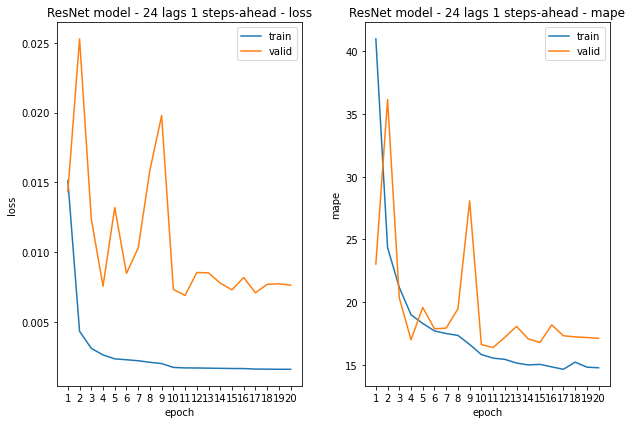

ResNet model - 24 lags 1 steps-ahead - train min loss: 0.001610	mae: 0.025879	mape: 14.773041	epoch: 20
ResNet model - 24 lags 1 steps-ahead - valid min loss: 0.006898	mae: 0.066897	mape: 16.385065	epoch: 11



In [26]:
h['resnet_24l_1s'] = run_model(models['resnet_24l_1s'], ds['train_24l_1s'], ds['valid_24l_1s'], epochs = 20)

Second, check multiple step-ahead predictions.

Model: "ResNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 24, 10)]     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 24, 64)       5184        input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 24, 64)       256         conv1d_33[0][0]                  
__________________________________________________________________________________________________
activation_27 (Activation)      (None, 24, 64)       0           batch_normalization_36[0][0]     
_____________________________________________________________________________________________

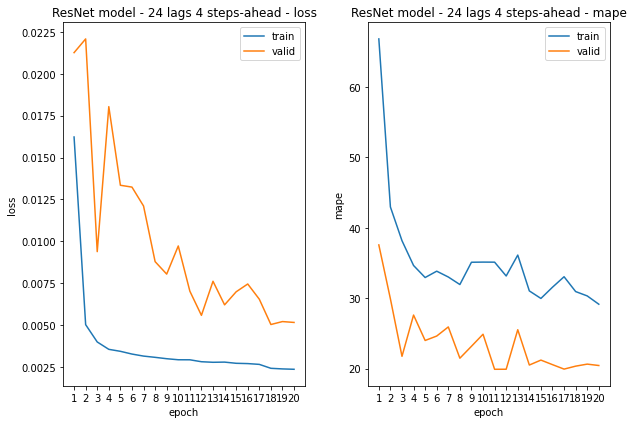

ResNet model - 24 lags 4 steps-ahead - train min loss: 0.002362	mae: 0.032584	mape: 29.151272	epoch: 20
ResNet model - 24 lags 4 steps-ahead - valid min loss: 0.005034	mae: 0.054451	mape: 20.356956	epoch: 18



In [27]:
h['resnet_24l_4s'] = run_model(models['resnet_24l_4s'], ds['train_24l_4s'], ds['valid_24l_4s'], epochs = 20)

### LSTM network

Long Short Term Memory networks, or LSTMs, were originally proposed in
[LONG SHORT TERM MEMORY](https://www.bioinf.jku.at/publications/older/2604.pdf).  They are recurrent neural networks which have feedback connections.

Residual neural networks use "identity shortcut connections" to skip over some layers.  Typical ResNet models are implemented with blocks of layers that contain nonlinearities (ReLU) and batch normalization.
Skipping over layers may avoid the problem of vanishing gradients, by reusing activations from a previous layer until the adjacent layer learns its weights.  This should allow training networks with more layers.

**TODO** Include basic LSTM diagram


Next, run the learning rate finder.

Epoch 1/5
18904/18904 [==============================] - 17s 803us/step - loss: 0.4271 - mae: 0.2629 - mape: 81.9289


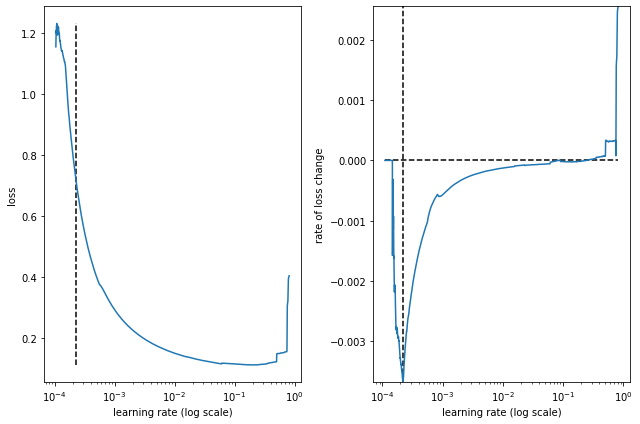

best lr: 0.00022147449 

Epoch 1/5
18869/18869 [==============================] - 17s 828us/step - loss: 0.4356 - mae: 0.2965 - mape: 113.6600


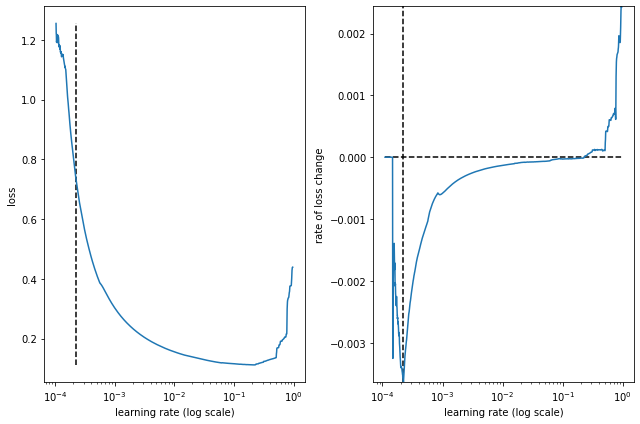

best lr: 0.00022354048 



In [14]:
from keras.callbacks import LambdaCallback
import keras.backend as K
import math


class LRFinder:
    """
    Plots the change of the loss function of a Keras model when the learning rate is exponentially increasing.
    See for details:
    https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0
    """

    def __init__(self, model):
        self.model = model
        self.losses = []
        self.lrs = []
        self.best_loss = 1e9

    def on_batch_end(self, batch, logs):
        # Log the learning rate
        lr = K.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)

        # Log the loss
        loss = logs['loss']
        self.losses.append(loss)

        # Check whether the loss got too large or NaN
        if batch > 5 and (math.isnan(loss) or loss > self.best_loss * 4):
            self.model.stop_training = True
            return

        if loss < self.best_loss:
            self.best_loss = loss

        # Increase the learning rate for the next batch
        lr *= self.lr_mult
        K.set_value(self.model.optimizer.lr, lr)

    def find_ds(self, train_ds, start_lr, end_lr, batch_size=64, epochs=1, **kw_fit):
        # If x_train contains data for multiple inputs, use length of the first input.
        # Assumption: the first element in the list is single input; NOT a list of inputs.
        # N = x_train[0].shape[0] if isinstance(x_train, list) else x_train.shape[0]
        N = train_ds.cardinality().numpy()

        # Compute number of batches and LR multiplier
        num_batches = epochs * N / batch_size
        self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(num_batches))
        #print(self.lr_mult)
        # Save weights into a file
        initial_weights = self.model.get_weights()

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.lr)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch, logs: self.on_batch_end(batch, logs))

        self.model.fit(train_ds,
                       batch_size=batch_size, epochs=epochs,
                       callbacks=[callback],
                       **kw_fit)

        # Restore the weights to the state before model fitting
        self.model.set_weights(initial_weights)

        # Restore the original learning rate
        K.set_value(self.model.optimizer.lr, original_lr)

    def plot_loss(self, axs, sma, n_skip_beginning=10, n_skip_end=5, x_scale='log'):
        """
        Plots the loss.
        Parameters:
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
        """
        lrs = self.lrs[n_skip_beginning:-n_skip_end]
        losses = self.losses[n_skip_beginning:-n_skip_end]
        best_lr = self.get_best_lr(sma=sma, n_skip_beginning=10, n_skip_end=5)

        axs[0].set_ylabel("loss")
        axs[0].set_xlabel("learning rate (log scale)")
        axs[0].plot(lrs, losses)
        axs[0].vlines(best_lr, np.min(losses), np.max(losses), linestyles='dashed')
        axs[0].set_xscale(x_scale)

    def plot_loss_change(self, axs, sma=1, n_skip_beginning=10, n_skip_end=5, y_lim=None):
        """
        Plots rate of change of the loss function.
        Parameters:
            axs - subplot axes
            sma - number of batches for simple moving average to smooth out the curve.
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
            y_lim - limits for the y axis.
        """
        derivatives = self.get_derivatives(sma)[n_skip_beginning:-n_skip_end]
        lrs = self.lrs[n_skip_beginning:-n_skip_end]
        best_lr = self.get_best_lr(sma=sma, n_skip_beginning=n_skip_beginning, n_skip_end=n_skip_end)
        y_min, y_max = np.min(derivatives), np.max(derivatives)
        x_min, x_max = np.min(lrs), np.max(lrs)

        axs[1].set_ylabel("rate of loss change")
        axs[1].set_xlabel("learning rate (log scale)")
        axs[1].plot(lrs, derivatives)
        axs[1].vlines(best_lr, y_min, y_max, linestyles='dashed')
        axs[1].hlines(0, x_min, x_max, linestyles='dashed')
        axs[1].set_xscale('log')
        if y_lim == None:
            axs[1].set_ylim([y_min, y_max])
        else:
            axs[1].set_ylim(y_lim)

    def get_derivatives(self, sma):
        assert sma >= 1
        derivatives = [0] * sma
        for i in range(sma, len(self.lrs)):
            derivatives.append((self.losses[i] - self.losses[i - sma]) / sma)
        return derivatives

    def get_best_lr(self, sma, n_skip_beginning=10, n_skip_end=5):
        derivatives = self.get_derivatives(sma)
        best_der_idx = np.argmin(derivatives[n_skip_beginning:-n_skip_end])
        return self.lrs[n_skip_beginning:-n_skip_end][best_der_idx]

    def summarise_lr(self, train_ds, start_lr, end_lr, batch_size=64, epochs=1, sma=1, n_skip_beginning=200, **kw_fit):
        self.find_ds(train_ds, start_lr, end_lr, batch_size, epochs)

        fig, axs = plt.subplots(1, 2, figsize = (9, 6), tight_layout = True)
        axs = axs.ravel()
        self.plot_loss(axs, sma)
        self.plot_loss_change(axs, sma=sma, n_skip_beginning=n_skip_beginning, n_skip_end=5)
        plt.show()

        best_lr = self.get_best_lr(sma=sma, n_skip_beginning=n_skip_beginning, n_skip_end=5)
        print("best lr:", best_lr, "\n")

 
def build_lstm_model(name, data, n_feature_maps = 32):
    in_shape, out_shape = get_io_shapes(data)
    out_steps = out_shape[0]
        
    #input_layer = keras.layers.Input(in_shape)
    ## Shape [batch, time, features] => [batch, lstm_units]
    ## Adding more `lstm_units` just overfits more quickly.
    #keras.layers.LSTM(n_feature_maps, return_sequences=False),
    ## Shape => [batch, out_steps*features]
    #keras.layers.Dense(out_steps*num_features,
    #                      kernel_initializer=tf.initializers.zeros()),
    ## Shape => [batch, out_steps, features]
    #keras.layers.Reshape([out_steps, num_features])


    lstm = Sequential(name = name)
    lstm.add(Input(shape = in_shape))

    # Shape [batch, time, features] => [batch, lstm_units]
    lstm.add(LSTM(n_feature_maps, return_sequences=False))

    # Shape => [batch, out_steps]
    lstm.add(Dense(out_steps,
                   kernel_initializer=tf.initializers.zeros()))
    
    # Shape => [batch, out_steps, features]
    #lstm.add(Reshape([out_steps, n_feature_maps]))
    # lstm.add(Reshape([out_steps]))

    #mlp.add(Reshape([1, -1]))

    return lstm


name = 'LSTM'
models['lstm_24l_1s'] = build_lstm_model(name, ds['train_24l_1s'])
models['lstm_24l_4s'] = build_lstm_model(name, ds['train_24l_4s'])

lrf = {}
model = models['lstm_24l_1s']
model.compile(loss = 'mse', metrics = ['mae', 'mape'])
lrf_lstm_24l_1s = LRFinder(model)
lrf_lstm_24l_1s.summarise_lr(ds['train_24l_1s'], 0.0001, 10, 32, 5, 100, 25)
lrf['lstm_24l_1s'] = lrf_lstm_24l_1s

model = models['lstm_24l_4s']
model.compile(loss = 'mse', metrics = ['mae', 'mape'])
lrf_lstm_24l_4s = LRFinder(model)
lrf_lstm_24l_4s.summarise_lr(ds['train_24l_4s'], 0.0001, 10, 32, 5, 100, 25)
lrf['lstm_24l_4s'] = lrf_lstm_24l_4s

Best learning rates from the learning rate finder are close to 0.0001.  So, lower than for FCNs and ResNets.

---

First, check single step-ahead predictions.

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 32)                5504      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 5,537
Trainable params: 5,537
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
18904/18904 - 94s - loss: 0.0019 - mae: 0.0285 - mape: 16.6343 - val_loss: 0.0018 - val_mae: 0.0290 - val_mape: 13.8386
Epoch 2/5
18904/18904 - 92s - loss: 0.0017 - mae: 0.0263 - mape: 14.7810 - val_loss: 0.0019 - val_mae: 0.0297 - val_mape: 13.9820
Epoch 3/5
18904/18904 - 92s - loss: 0.0016 - mae: 0.0258 - mape: 14.6853 - val_loss: 0.0016 - val_mae: 0.0266 - val_mape: 12.9716
Epoch 4/5
18904/18904 - 91s - loss: 0.0016 - mae: 0.0255 - mape: 14.4244 - val_loss: 0.0017 - val_mae: 0.0271 - val_mape: 13.0372
Ep

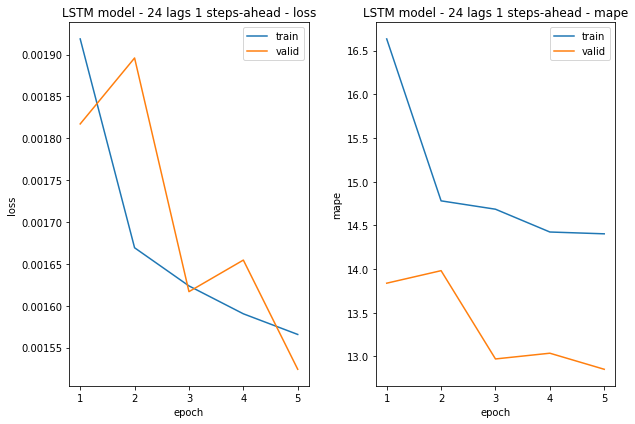

LSTM model - 24 lags 1 steps-ahead - train min loss: 0.001566	mae: 0.025322	mape: 14.403658	epoch: 5
LSTM model - 24 lags 1 steps-ahead - valid min loss: 0.001524	mae: 0.025770	mape: 12.853312	epoch: 5



In [16]:
h['lstm_24l_1s'] = run_model(models['lstm_24l_1s'], ds['train_24l_1s'], ds['valid_24l_1s'], epochs = 5)

Second, check multiple step-ahead predictions.

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 32)                5504      
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 132       
Total params: 5,636
Trainable params: 5,636
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
18869/18869 - 95s - loss: 0.0058 - mae: 0.0427 - mape: 36.9161 - val_loss: 0.0031 - val_mae: 0.0385 - val_mape: 18.8825
Epoch 2/5
18869/18869 - 94s - loss: 0.0028 - mae: 0.0352 - mape: 34.0731 - val_loss: 0.0026 - val_mae: 0.0351 - val_mape: 18.0520
Epoch 3/5
18869/18869 - 92s - loss: 0.0027 - mae: 0.0346 - mape: 32.2067 - val_loss: 0.0026 - val_mae: 0.0349 - val_mape: 18.2957
Epoch 4/5
18869/18869 - 93s - loss: 0.0026 - mae: 0.0343 - mape: 30.9353 - val_loss: 0.0026 - val_mae: 0.0345 - val_mape: 17.9205
Ep

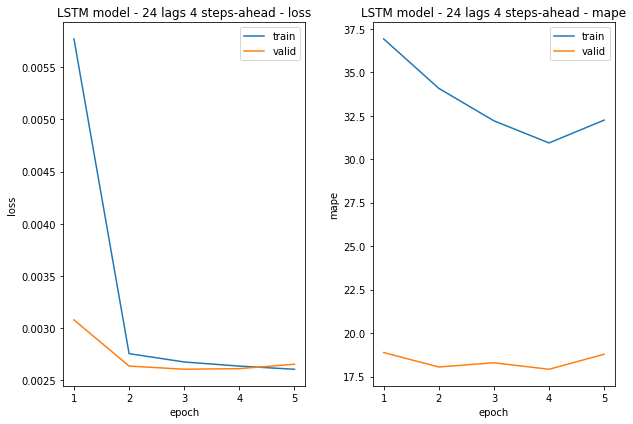

LSTM model - 24 lags 4 steps-ahead - train min loss: 0.002605	mae: 0.034075	mape: 32.247261	epoch: 5
LSTM model - 24 lags 4 steps-ahead - valid min loss: 0.002605	mae: 0.034851	mape: 18.295666	epoch: 3



In [18]:
h['lstm_24l_4s'] = run_model(models['lstm_24l_4s'], ds['train_24l_4s'], ds['valid_24l_4s'], epochs = 5)

### Architecture comparison/test data results

Both LSTM models have lower rmse and mae for both training and validation data sets.

| Architecture | Steps ahead | Train rmse | Train mae | Valid rmse| Valid mae|
|--------------|-------------|------------|-----------|-----------|----------|
| MLP          | 1           | 0.0016     | 0.025     | 0.0015    | 0.025    |
| MLP          | 4           | 0.003      | 0.037     | 0.0029    | 0.037    |
| FCN          | 1           | 0.0016     | 0.026     | 0.0022    | 0.034    |
| FCN          | 4           | 0.0028     | 0.036     | 0.0032    | 0.041    |
| ResNet       | 1           | 0.0016     | 0.026     | 0.0069    | 0.067    |
| ResNet       | 4           | 0.0024     | 0.033     | 0.005     | 0.054    |
| LSTM         | 1           | 0.0012     | 0.022     | 0.0012    | 0.023    |
| LSTM         | 4           | 0.0024     | 0.032     | 0.0023    | 0.032    |

None of the architectures were heavily optimised.  I assume the unoptimised FCN and ResNet models are over-parameterised and check the LSTM models on the test data.  

The test data covers all of 2019.  I check the 1 step ahead and the 4 steps ahead forecasts on the inverse transformed predictions (temperature in C * 10) using three plots:
 * predicted vs observed
 * residuals vs time
 * residual density plot

**TODO** Add plot of 9 temperature examples (observations, predictions and labels) from 2019 data
 * use previous 3 * 3 plot matrix
 * include observed and predicted values as title
 * see `plot_examples()` but only for temperature data

Plus two summary values:
 * root mean square error
 * median absolute error

t rmse LSTM 24l 1s: 7.159888
t mae LSTM 24l 1s:  3.5075378


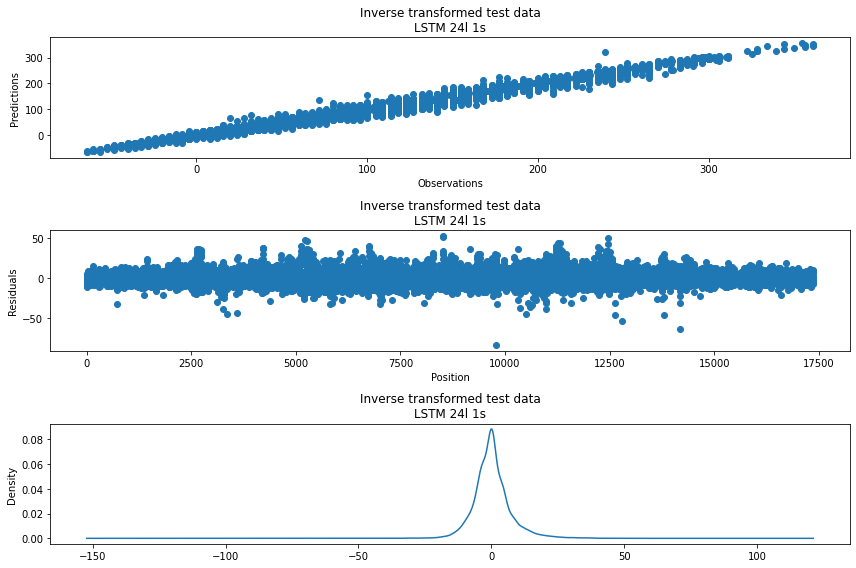




t rmse LSTM 24l 4s: 13.730055
t mae LSTM 24l 4s:  6.0605354


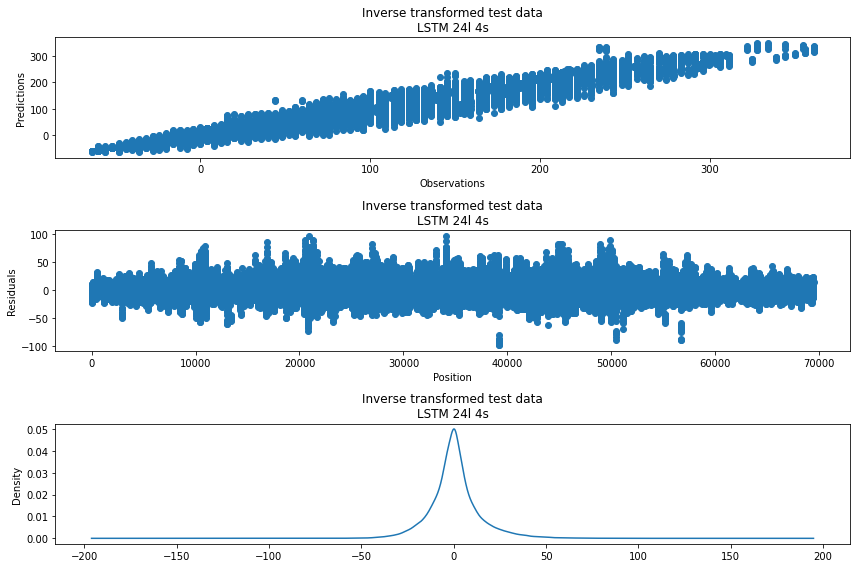

In [19]:
def plot_obs_preds(obs, preds, title):
    plt.figure(figsize = (12, 8))
    plt.subplot(3, 1, 1)
    plt.scatter(x = obs, y = preds)
    plt.xlabel('Observations')
    plt.ylabel('Predictions')
    plt.title(title)


def plot_residuals(obs, preds, title):
    plt.subplot(3, 1, 2)
    plt.scatter(x = range(len(obs)), y = (obs - preds))
    plt.xlabel('Position')
    plt.ylabel('Residuals')
    plt.title(title)


def plot_residuals_dist(obs, preds, title):
    data = obs - preds
    plt.subplot(3, 1, 3)
    pd.Series(data).plot(kind = 'density')
    plt.title(title)
    plt.tight_layout()
    plt.show()


def rmse(obs, preds):
    return np.sqrt(np.mean((obs - preds) ** 2))


def mae(obs, preds):
    return np.median(np.abs(obs - preds))


def check_test_data(model, test, desc):
    preds = model.predict(test)
    obs   = np.concatenate([y for _, y in test], axis = 0)

    # reshape obs & preds
    label_len = obs.shape[0]
    preds_len = len(preds)
    # print("labels:", label_len)
    # print("preds:",  preds_len)
    # print("preds:",  preds.shape)
    # print("obs:",    obs.shape)
    assert label_len == preds_len

    # print("obs[0]:", obs.shape[0])
    # print("obs[1]:", obs.shape[1])
    preds_long = preds.reshape((obs.shape[0] * obs.shape[1]))
    test_long  = obs.reshape((obs.shape[0] * obs.shape[1]))

    # inverse transform using train mean & sd
    y_train_mean = train_mean[0]
    y_train_std  = train_std[0]

    t_preds = preds_long * y_train_std + y_train_mean
    t_obs   =  test_long * y_train_std + y_train_mean

    t_rmse = rmse(t_obs, t_preds)  # Need to treat 4 step ahead rmse & mae properly
    t_mae  =  mae(t_obs, t_preds)
    print("t rmse ", desc, ": ",  t_rmse, sep = '')
    print("t mae ",  desc, ":  ", t_mae,  sep = '')

    title = 'Inverse transformed test data\n' + desc
    plot_obs_preds(t_obs, t_preds, title)
    plot_residuals(t_obs, t_preds, title)
    plot_residuals_dist(t_obs, t_preds, title)
    print("\n\n")


check_test_data(models['lstm_24l_1s'], ds['test_24l_1s'], 'LSTM 24l 1s')
check_test_data(models['lstm_24l_4s'], ds['test_24l_4s'], 'LSTM 24l 4s')


From the plots, its worth noting:
 * observations, predictions and residuals should be divided by 10 to get temperature in C
 * there is good agreement between observations and predictions for 1 step ahead forecasts
 * as expected 4 step ahead predictions are worse than 1 step ahead
 * residuals appear to be normally distributed
 * observations are relatively sparse above 32 C in 2019
 * there is at least one obvious outlier in the 2019 test data


### Test time augmentation

Test time augmentation (TTA) is a technique that can boost a model's performance by applying augmentation during inference.  Inference is performed on multiple augmented versions of the same test data.  It's commonly applied to image data using flips, rotations etc.  Predictions on the augmented data are then averaged.

Here I use mixup to augment the test data.  I arbitrarily choose to add 5 mixup augmented versions of each test data observation.  The `tta_mixup` function is a simplified version of the previously used `mixup` function.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


t rmse LSTM 24l 1s TTA: 6.594361
t mae LSTM 24l 1s TTA:  3.3252563


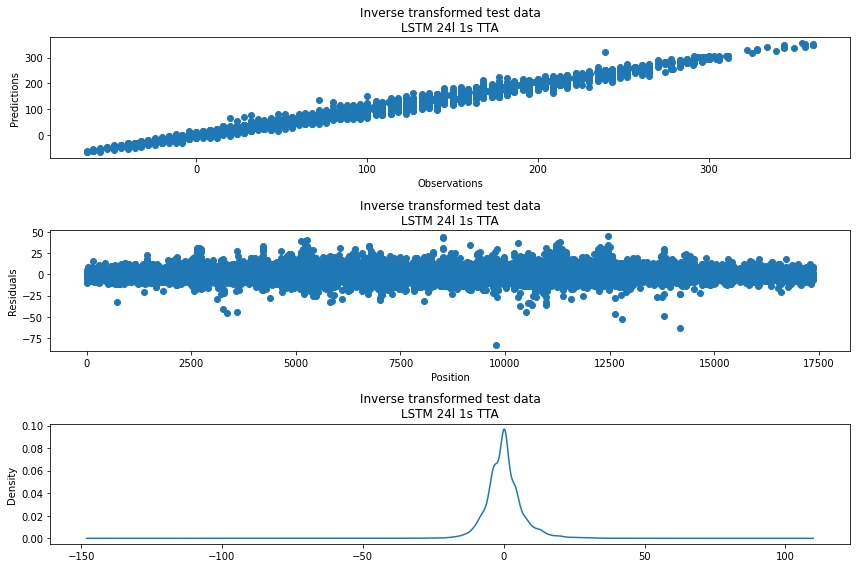

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


t rmse LSTM 24l 4s TTA: 13.168447
t mae LSTM 24l 4s TTA:  5.8312283


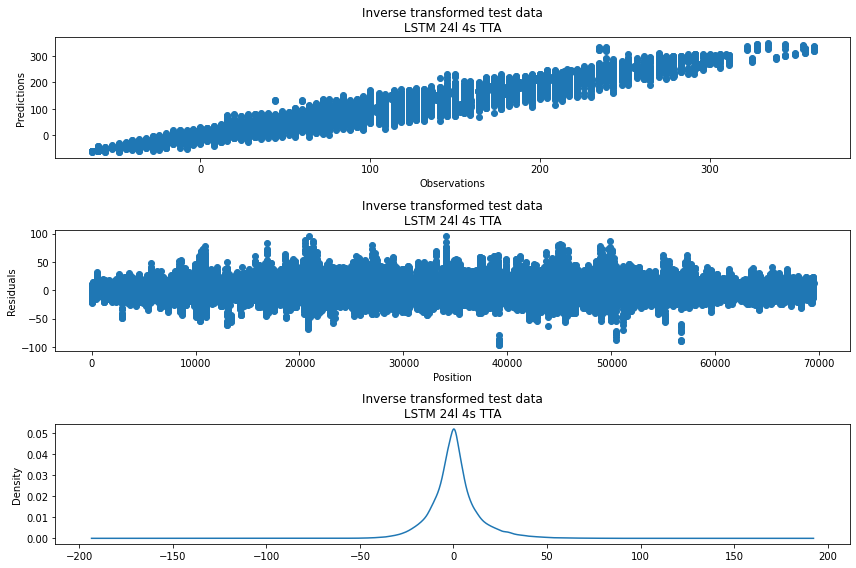

In [20]:
class TTA_ModelWrapper():
    """A TTA wrapper for keras time series models.
    Args:
        model: A fitted keras model with a predict method.
    """

    def __init__(self, model):
        self.model = model

    def predict(self, X):
        """Wraps the predict method of the provided model.
        Augments the test data with the mixup method and
        averages the results.
        Args:
            X: The data to get predictions for.
        """

        def tta_mixup(batch, alpha = 1.0):
            batch_mix = []
            for data in batch:
              data_size = len(data) - 1
    
              # random sample lambda value from beta distribution
              l   = np.random.beta(alpha, alpha, data_size)
              X_l = l.reshape(data_size, 1)
    
              # Get a pair of outputs
              X1 = data[1:data_size + 1]    
              X2 = data[0:data_size]

              # Perform mixup
              X_mix = X1 * X_l + X2 * (1 - X_l)
              X_mix = np.vstack([X_mix, data[data_size]])
              batch_mix.append(X_mix)
    
            return np.array(batch_mix)

        mixups = 5  # 5 is an arbitrary value
        preds = []
        for x_i, _ in X.as_numpy_iterator():
          p = self.model.predict(x_i)
          for m in range(mixups):
            p_m = self.model.predict(tta_mixup(x_i, alpha = (m + 1) * 1.0))
            p = p + p_m
          p = p / (mixups + 1)
          preds.append(p)

        return np.concatenate([p for p in np.array(preds)], axis = 0)


models['lstm_24l_1s_tta'] = TTA_ModelWrapper(models['lstm_24l_1s'])
models['lstm_24l_4s_tta'] = TTA_ModelWrapper(models['lstm_24l_4s'])

check_test_data(models['lstm_24l_1s_tta'], ds['test_24l_1s'], 'LSTM 24l 1s TTA')
check_test_data(models['lstm_24l_4s_tta'], ds['test_24l_4s'], 'LSTM 24l 4s TTA')

Mixup TTA improved the rmse and mae values for 1 step ahead forecasts more than the 4 step ahead forecasts on the test data.

|  Augmentation   | Steps ahead | rmse  | mae  |
|-----------------|-------------|-------|------|
| No augmentation |      1      |  7.45 | 3.94 |
| Mixup TTA       |      1      |  6.99 | 3.78 |
| No augmentation |      4      | 13.72 | 6.47 |
| Mixup TTA       |      4      | 13.35 | 6.21 |

Once again, these rmse and mae values should be divided by 10 to get temperature values in C.

---


## Conclusion

Unfortunately, the root mean square error and mean absolute error values from the unaugmented test data do not improve on the [baseline methods](https://github.com/makeyourownmaker/CambridgeTemperatureModel) or my earlier [prophet model](https://github.com/makeyourownmaker/BayesianProphet/).  Strictly speaking these values are not comparable.

The test time augmentation with mixup improves the mean absolute error value for single step ahead forecasts compared to the baseline methods.

There is considerable scope for optimising both train time and test time mixup augmentation:
  * optimise amount of mixup and mixup parameters
  * mixup between todays observations and yesterdays (assumming a window of a single days observations; train time only)
    * this could be further extended to previous days up to a point
  * switch to mini-batch mixup (train time only)
  * more care may need to be applied when removing outliers
  * [CutMix: Regularization Strategy to Train Strong Classifiers with Localizable Features](https://arxiv.org/abs/1905.04899) could be considered

On an unrelated matter, validation loss values below training loss values indicate problems with validation data.  This may be due to redundancy between training and validation data sets.

Additional future work:
 * add standard deviations to MSE, MAE and MAPE values
 * examine using simple exponential smoothing for interpolation
 * optimise architectures with [keras-tuner](https://github.com/keras-team/keras-tuner)
   * move off Colab to AWS or similar to avoid time-outs
 * additional regressors
   * possibly from freely available [Global Forecast System](https://www.ncdc.noaa.gov/data-access/model-data/model-datasets/global-forcast-system-gfs) model
     * and/or worth investigating for missing value substitution
 * decorrelate input variables
   * consider deseasonalising (daily & annual) pressure, humidity, wind etc
 * move some code to module(s) for reuse
   * particularly data preparation
 * add explanatory figures and example plots - see marked TODOs

---

## Metadata

Python and Jupyter versions plus modules imported and their version strings. 
This is the poor man's python equivalent of R's sessionInfo().

Code for imported modules and versions adapted from this stackoverflow answer. 
There are simpler alternatives, such as watermark, but they all require installation.

In [ ]:
import sys
import IPython

print("Python version:")
print(sys.executable)
print(sys.version)
print("\nIPython version:")
print(IPython.__version__)

In [ ]:
import pkg_resources
import types

def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names.  Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name.  You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL":       "Pillow",
            "sklearn":   "scikit-learn",
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name

imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name != "pip":
        requirements.append((m.project_name, m.version))

reqs = pd.DataFrame(requirements, columns = ['name', 'version'])
print("Imported modules:")
reqs.style.hide_index()

In [ ]:
!date

---


## Archival

Archive code, markdown, history and formatted notebooks.

Assumes all pdf, html, latex etc dependencies are installed.

**WARNING** Will overwrite existing files.

Notebook name is hardcoded below because the alternative is ghastly globs of unreliable javascript or external ipython libraries I'd prefer to avoid installing :-(

In [ ]:
from time import sleep

notebook = "keras_mlp_fcn_resnet_time_series.ipynb"
# !jupyter nbconvert --to script {notebook}
# !jupyter nbconvert --execute --to html {notebook}
# !jupyter nbconvert --execute --to pdf {notebook}
# !jupyter nbconvert --to pdf {notebook}

%rm history.txt
%history -f history.txt

!jupyter nbconvert --to python {notebook}
sleep(5)
!jupyter nbconvert --to markdown {notebook}
sleep(5)
!jupyter nbconvert --to html {notebook}